Make a XKCD Plot of LOTR
========================

Aim to load the book from a .mobi converted to .epub, and read using ebooklib.

Need to:
- find the characters
- identify characters through time
- define when characters are together


In [131]:
isbn = 9780618574940

In [132]:
from os import listdir
from os.path import isfile, join
import sys
sys.path.append("/Users/andyreagan/tools/python")
from kitchentable.dogtoys import *
from json import loads
from re import findall,UNICODE
from labMTsimple.labMTsimple.speedy import LabMT
import numpy as np

In [133]:
def listify(raw_text,lang="en"):
    """Make a list of words from a string."""

    punctuation_to_replace = ["---","--","''"]
    for punctuation in punctuation_to_replace:
        raw_text = raw_text.replace(punctuation," ")
    words = [x.lower() for x in findall(r"[\w\@\#\'\&\]\*\-\/\[\=\;]+",raw_text,flags=UNICODE)]

    return words

class book(object):
    '''Book class to handle loading the calibre expanded epub format.
    
    Store all of the word lists, etc, in one place.'''
    
    def load_all(self,isbn):
        self.files = listdir("data/Kindle-combined-txt/"+str(isbn))
        self.txtfiles = listdir("data/Kindle-combined-txt/"+str(isbn)+"/txt")        

        print("a sample of the text files:")
        print(txtfiles[:10])
        f = open("data/Kindle-combined-txt/"+str(isbn)+"/meta.json","r")
        self.metadata = loads(f.read())
        f.close()
        print("this is the metadata:")
        print(self.metadata)
        self.rawtext_by_chapter = []
        for fname in txtfiles:
            f = open("data/Kindle-combined-txt/"+str(isbn)+"/txt/"+fname,"r")
            self.rawtext_by_chapter.append(f.read())
            f.close()
        self.word_lists_by_chapter = [listify(t) for t in self.rawtext_by_chapter]
        self.chapter_ends = np.cumsum(list(map(len,self.word_lists_by_chapter)))
        # add a 0 to the start, clip (to get the starts)
        # could just move the above array around too...
        self.chapter_beginnings = np.cumsum([0]+list(map(len,self.word_lists_by_chapter[:-1])))
        self.chapter_centers = (self.chapter_ends+self.chapter_beginnings)/2
#         print(list(map(len,self.word_lists_by_chapter)))
#         print(self.chapter_ends)
#         print(self.chapter_beginnings)
#         print(self.chapter_centers)
#         print(len(self.chapter_ends))
#         print(len(self.word_lists_by_chapter))
        
    def chop(self,my_senti_dict,min_size=1000): #,save=False,outfile=""):
        """Take long piece of text and generate the sentiment time series.

        use save parameter to write timeseries to a file."""
        print("splitting the book into chunks of minimum size {}".format(min_size))
        
        self.all_words = " ".join(self.rawtext_by_chapter)
        self.all_word_list = listify(self.all_words)
        
        self.all_fvec = []

        for i in range(int(np.floor(len(self.all_word_list)/min_size))):
            chunk = ""
            if i == int(np.floor(len(self.all_word_list)/min_size))-1:
                # take the rest
                print('last chunk')
                print('getting words ' + str(i*min_size) + ' through ' + str(len(self.all_word_list)-1))
                for j in range(i*min_size,len(self.all_word_list)-1):
                    chunk += self.all_word_list[j]+" "
            else:
                print('getting words ' + str(i*min_size) + ' through ' + str((i+1)*min_size))
                for j in range(i*min_size,(i+1)*min_size):
                    chunk += self.all_word_list[j]+" "
                # print(chunk[0:10])

            chunk_words = listify(chunk)
            chunk_dict = dict()
            for word in chunk_words:
                if word in chunk_dict:
                    chunk_dict[word] += 1
                else:
                    chunk_dict[word] = 1
            text_fvec = my_senti_dict.wordVecify(chunk_dict)

            # print chunk
            # print 'the valence of {0} part {1} is {2}'.format(rawbook,i,textValence)

            self.all_fvec.append(text_fvec)

        return self.all_fvec
    
    def chopper_sliding(self,my_senti_dict,min_size=10000,num_points=100,stop_val=0.0,return_centers=False):
        """Take long piece of text and generate the sentiment time series.
        We will now slide the window along, rather than make uniform pieces.

        use save parameter to write timeseries to a file."""

        print("splitting the book into {} chunks of minimum size {}".format(num_points,min_size))

        # print("and printing those frequency vectors"

        # initialize timeseries, only thing we're after
        timeseries = [0 for i in range(num_points)]
        all_fvecs = [np.zeros(len(my_senti_dict.scorelist)) for i in range(num_points)]
        window_centers = [0 for i in range(num_points)]

        # how much to jump
        # take one chunk out, and divide by the number of others we want (-1, the one we just took out)
        # take the floor of this as the step, so we may take slightly smaller steps than possible
        step = int(np.floor((len(self.all_word_list)-min_size)/(num_points-1)))
        print("there are "+str(len(self.all_word_list))+" words in the book")
        print("step size "+str(step))

        # do it 99 times
        for i in range(num_points-1):
            window_centers[i] = i*step+(min_size)/2
            # build the whole dict each time (could be a little better about this)
            window_dict = dict()
            # print("using words {} through {}".format(i*step,min_size+i*step))
            for word in self.all_word_list[(i*step):(min_size+i*step)]:
                if word in window_dict:
                    window_dict[word] += 1
                else:
                    window_dict[word] = 1
            text_fvec = my_senti_dict.wordVecify(window_dict)
            stoppedVec = stopper(text_fvec,my_senti_dict.scorelist,my_senti_dict.wordlist,stopVal=stop_val)
            timeseries[i] = np.dot(my_senti_dict.scorelist,stoppedVec)/np.sum(stoppedVec)
            all_fvecs[i] = text_fvec

        # final chunk
        i = num_points-1
        window_centers[i] = i*step+(min_size)/2
        # only difference: go to the end
        # may be 10-100 more words there (we used floor on the step)
        window_dict = dict()
        # print("using words {} through {}".format(i*step,len(all_words)))
        for word in self.all_word_list[(i*step):]:
            if word in window_dict:
                window_dict[word] += 1
            else:
                window_dict[word] = 1
        text_fvec = my_senti_dict.wordVecify(window_dict)
        stoppedVec = stopper(text_fvec,my_senti_dict.scorelist,my_senti_dict.wordlist,stopVal=stop_val)
        timeseries[i] = np.dot(my_senti_dict.scorelist,stoppedVec)/np.sum(stoppedVec)
        all_fvecs[i] = text_fvec

        if return_centers:
            return timeseries,all_fvecs,window_centers

        return timeseries,all_fvecs
        # timeseries = coursegrain(timeseries,points=21)

    #     g = open(outfile,"w")
    #     g.write("{0:.0f}".format(timeseries[0]))
    #     for i in range(1,numPoints):
    #         g.write(",")
    #         g.write("{0:.0f}".format(timeseries[i]))
    #     g.write("\n")

    def __init__(self,isbn):
        self.isbn = isbn
        self.load_all(isbn)
        
    def __str__(self):
        if "title" in self.metadata:
            return self.metadata["title"]
        else:
            return "Book (no title)"

In [134]:
my_book = book(isbn)
print(my_book)

a sample of the text files:
['index_split_000.txt', 'index_split_001.txt', 'index_split_002.txt', 'index_split_003.txt', 'index_split_004.txt', 'index_split_005.txt', 'index_split_006.txt', 'index_split_007.txt', 'index_split_008.txt', 'index_split_009.txt']
this is the metadata:
{'book producer': 'calibre (2.49.0) [http://calibre-ebook.com]', 'languages': 'eng', 'author(s)': 'J. R. R. Tolkien', 'tags': 'Juvenile Fiction, Classics, Fantasy fiction, Fiction - Fantasy, Gandalf (Fictitious character), Epic, Middle Earth (Imaginary place), Fantasy - Epic, 1892-1973, J. R. R. (John Ronald Reuel), Adventure fiction, Frodo (Fictitious character), Children: Grades 4-6, Elves, Fiction, Rings, Fantasy & Magic, Fantasy, Tolkien, Baggins, Epic fiction', 'title': 'The Fellowship of the Ring', 'identifiers': 'isbn:9780618574940', 'published': '2005-07-15T07:00:00+00:00', 'timestamp': '2016-01-25T00:19:48.324916+00:00', 'comments': 'SUMMARY: For over fifty years, J.R.R. Tolkien’s peerless fantasy has

In [135]:
import matplotlib.pyplot as plt
%matplotlib inline

[     0.   2000.   4000.   6000.   8000.  10000.  12000.  14000.  16000.
  18000.]


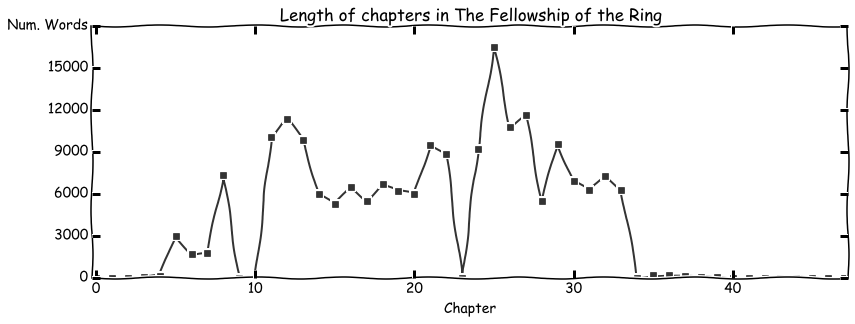

In [136]:
plt.xkcd()

fig = plt.figure(figsize=(15,5)) #,dpi=600)
ax = fig.add_axes([.2,.2,.7,.7])

ax.plot([len(w) for w in my_book.word_lists_by_chapter],linestyle="-",marker="s",color="0.2",markerfacecolor="0.2")
ax.set_xlim([-.25,len(my_book.word_lists_by_chapter)-.75])
ax.set_xlabel("Chapter")
print(ax.yaxis.get_ticklocs())
# ax.set_ylabel("Number of words",rotation=0,verticalalignment='center',horizontalalignment='right',)
ax.set_yticks([0,3000,6000,9000,12000,15000,18000])
ax.set_yticklabels([0,3000,6000,9000,12000,15000,"Num. Words"])
ax.set_title("Length of chapters in {}".format(str(my_book)))
# ax.
plt.savefig("media/figures/"+str(my_book.isbn)+".png",bbox_inches='tight',dpi=150)

In [137]:
my_LabMT = LabMT(stopVal=0.0)

loading LabMT with stopVal=0.0, for 10222 words


chopper from chopgutenberg.py
-----------------------------
could be more code on the server too...

- chop.py has very similar code.
- chopuniform.py chops them into stories of the same length

*** moved these methods inside the class

In [138]:
all_fvecs = my_book.chop(my_LabMT)

splitting the book into chunks of minimum size 1000
getting words 0 through 1000
getting words 1000 through 2000
getting words 2000 through 3000
getting words 3000 through 4000
getting words 4000 through 5000
getting words 5000 through 6000
getting words 6000 through 7000
getting words 7000 through 8000
getting words 8000 through 9000
getting words 9000 through 10000
getting words 10000 through 11000
getting words 11000 through 12000
getting words 12000 through 13000
getting words 13000 through 14000
getting words 14000 through 15000
getting words 15000 through 16000
getting words 16000 through 17000
getting words 17000 through 18000
getting words 18000 through 19000
getting words 19000 through 20000
getting words 20000 through 21000
getting words 21000 through 22000
getting words 22000 through 23000
getting words 23000 through 24000
getting words 24000 through 25000
getting words 25000 through 26000
getting words 26000 through 27000
getting words 27000 through 28000
getting words 2800

In [139]:
all_fvecs

[array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  1., ...,  0.,  0.,  0.]),
 array([ 1.,  0.,  1., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  1., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 1.,  0.,  1., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0

In [140]:
from labMTsimple.labMTsimple.storyLab import *

In [141]:
happs_vec = [np.dot(my_LabMT.scorelist,fvec)/np.sum(fvec) for fvec in my_book.all_fvec]
print(happs_vec)

[5.3768181818181819, 5.3227750611246938, 5.3543010752688165, 5.3687587006960555, 5.3590232558139537, 5.2493114754098373, 5.3349392265193378, 5.3836050516647544, 5.2648797250859118, 5.2704840613931525, 5.3565242494226331, 5.2704627539503379, 5.2318110236220479, 5.3557611241217797, 5.4099019607843131, 5.3463805104408353, 5.3815266272189364, 5.4037278106508886, 5.4042530120481933, 5.3870446735395179, 5.4052600472813239, 5.3600355029585804, 5.3358645707376064, 5.3826258992805762, 5.2941608391608383, 5.3280496453900703, 5.3402270147559587, 5.2933218390804591, 5.3201028571428575, 5.3740977881257272, 5.258670520231215, 5.3000800915331814, 5.1947880870561285, 5.2430502793296094, 5.3332646048109957, 5.3074178403755869, 5.3485764294049005, 5.3246198156682025, 5.3239135514018701, 5.2971791907514456, 5.3151393534002223, 5.3575791855203621, 5.3958245614035087, 5.423760479041916, 5.346152941176471, 5.4454501800720285, 5.331013824884792, 5.2480200222469406, 5.3633612440191394, 5.3655504587155969, 5.3

[ 5.1   5.15  5.2   5.25  5.3   5.35  5.4   5.45  5.5   5.55]


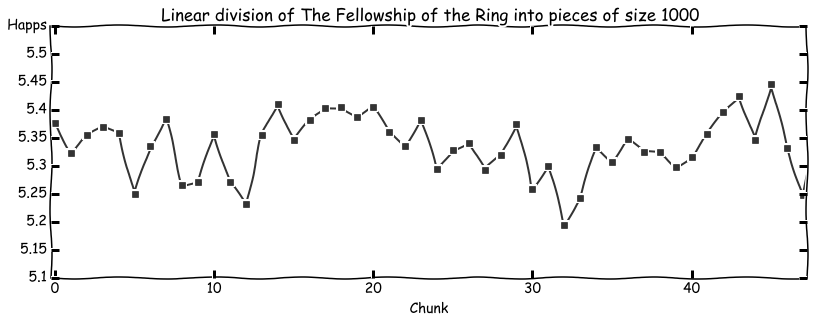

In [142]:
# plt.xkcd()

fig = plt.figure(figsize=(15,5)) #,dpi=600)
ax = fig.add_axes([.2,.2,.7,.7])

ax.plot(happs_vec,linestyle="-",marker="s",color="0.2",markerfacecolor="0.2")
ax.set_xlim([-.25,len(my_book.word_lists_by_chapter)-.75])
ax.set_xlabel("Chunk")
# ax.set_ylabel("Happs",rotation=0)
print(ax.yaxis.get_ticklocs())
new_ticks = [x for x in ax.yaxis.get_ticklocs()]
ax.set_yticks(new_ticks)
new_ticks[-1] = "Happs"
ax.set_yticklabels(new_ticks)
# ax.set_ylabel("Number of words",rotation=0,verticalalignment='center',horizontalalignment='right',)
# ax.set_yticks([0,3000,6000,9000,12000,15000,18000])
# ax.set_yticklabels([0,3000,6000,9000,12000,15000,"Num. Words"])
ax.set_title("Linear division of {} into pieces of size 1000".format(str(my_book)))
# ax.
# plt.savefig("media/figures/"+str(isbn)+".png",bbox_inches='tight',dpi=150)

In [143]:
chapter_happs = []
chapter_happs_center = []
for i in range(len(my_book.chapter_centers)):
    if len(my_book.word_lists_by_chapter[i]) > 1000:
        chapter_dict = dict()
        for word in my_book.word_lists_by_chapter[i]:
            if word in chapter_dict:
                chapter_dict[word] += 1
            else:
                chapter_dict[word] = 1
        chapter_fvec = my_LabMT.wordVecify(chapter_dict)
        happs = np.dot(my_LabMT.scorelist,chapter_fvec)/np.sum(chapter_fvec)
        chapter_happs.append(happs)
        chapter_happs_center.append(my_book.chapter_centers[i])

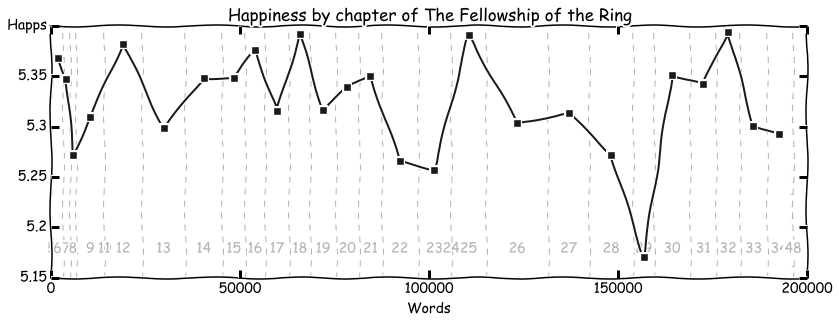

In [144]:
# plt.rcdefaults()
# %matplotlib inline
plt.xkcd()
fig = plt.figure(figsize=(15,5)) #,dpi=600)
ax = fig.add_axes([.2,.2,.7,.7])

ax.plot(chapter_happs_center,chapter_happs,linestyle="-",marker="s",color="0.1",markerfacecolor="0.1",zorder=2)
# ax.set_xlim([-.25,len(word_lists_by_chapter)-.75])
ax.set_xlabel("Words")


for i,end in enumerate(my_book.chapter_ends):
    ax.plot([end,end],[ax.yaxis.get_ticklocs()[0],ax.yaxis.get_ticklocs()[-1]],'--',linewidth=1.0,color="0.7",zorder=1)
    ax.text(my_book.chapter_centers[i],ax.yaxis.get_ticklocs()[0]+0.025,i+1,horizontalalignment='center',color="0.7",zorder=1)
    
new_ticks = [x for x in ax.yaxis.get_ticklocs()]
ax.set_yticks(new_ticks)
new_ticks[-1] = "Happs"
ax.set_yticklabels(new_ticks)
    
# ax.plot(chapter_happs_center,chapter_happs,linestyle="-",marker="s",color="0.1",markerfacecolor="0.1",zorder=1)

ax.set_title("Happiness by chapter of {}".format(str(my_book)))

In [145]:
timeseries_10000_100,all_fvecs = my_book.chopper_sliding(my_LabMT)
timeseries_10000_50,all_fvecs = my_book.chopper_sliding(my_LabMT,num_points=50)

splitting the book into 100 chunks of minimum size 10000
there are 196327 words in the book
step size 1882
splitting the book into 50 chunks of minimum size 10000
there are 196327 words in the book
step size 3802


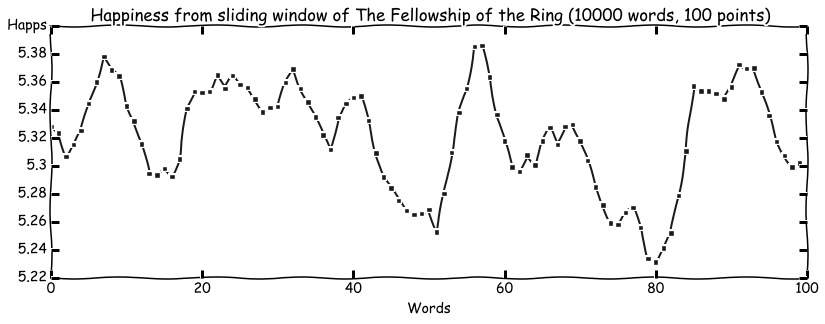

In [147]:
# plt.rcdefaults()
# %matplotlib inline
plt.xkcd()
fig = plt.figure(figsize=(15,5)) #,dpi=600)
ax = fig.add_axes([.2,.2,.7,.7])

ax.plot(timeseries_10000_100,linestyle="-",marker="s",color="0.1",markerfacecolor="0.1",markersize=3.5,zorder=2)
# ax.set_xlim([-.25,len(word_lists_by_chapter)-.75])
ax.set_xlabel("Words")


# for i,end in enumerate(chapter_ends):
#     ax.plot([end,end],[ax.yaxis.get_ticklocs()[0],ax.yaxis.get_ticklocs()[-1]],'--',linewidth=1.0,color="0.7",zorder=1)
#     ax.text(chapter_centers[i],ax.yaxis.get_ticklocs()[0]+0.025,i+1,horizontalalignment='center',color="0.7",zorder=1)
    
new_ticks = [x for x in ax.yaxis.get_ticklocs()]
ax.set_yticks(new_ticks)
new_ticks[-1] = "Happs"
ax.set_yticklabels(new_ticks)
    
# ax.plot(chapter_happs_center,chapter_happs,linestyle="-",marker="s",color="0.1",markerfacecolor="0.1",zorder=1)

ax.set_title("Happiness from sliding window of {} (10000 words, 100 points)".format(str(my_book)))

splitting the book into 200 chunks of minimum size 10000
there are 196327 words in the book
step size 936


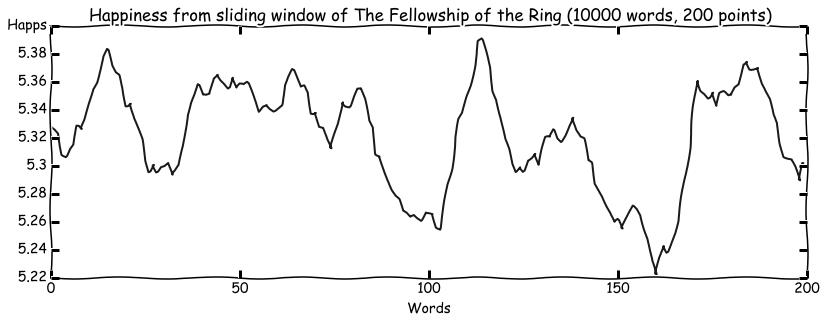

In [148]:
timeseries_10000_200,all_fvecs = my_book.chopper_sliding(my_LabMT,num_points=200)
# plt.rcdefaults()
# %matplotlib inline
plt.xkcd()
fig = plt.figure(figsize=(15,5)) #,dpi=600)
ax = fig.add_axes([.2,.2,.7,.7])

ax.plot(timeseries_10000_200,linestyle="-",marker="",color="0.1",markerfacecolor="0.1",markersize=3.5,zorder=2)
# ax.set_xlim([-.25,len(word_lists_by_chapter)-.75])
ax.set_xlabel("Words")


# for i,end in enumerate(chapter_ends):
#     ax.plot([end,end],[ax.yaxis.get_ticklocs()[0],ax.yaxis.get_ticklocs()[-1]],'--',linewidth=1.0,color="0.7",zorder=1)
#     ax.text(chapter_centers[i],ax.yaxis.get_ticklocs()[0]+0.025,i+1,horizontalalignment='center',color="0.7",zorder=1)
    
new_ticks = [x for x in ax.yaxis.get_ticklocs()]
ax.set_yticks(new_ticks)
new_ticks[-1] = "Happs"
ax.set_yticklabels(new_ticks)
    
# ax.plot(chapter_happs_center,chapter_happs,linestyle="-",marker="s",color="0.1",markerfacecolor="0.1",zorder=1)

ax.set_title("Happiness from sliding window of {} (10000 words, 200 points)".format(my_book.metadata["title"]))

splitting the book into 100 chunks of minimum size 20000
there are 196327 words in the book
step size 1781
splitting the book into 200 chunks of minimum size 20000
there are 196327 words in the book
step size 886
splitting the book into 500 chunks of minimum size 20000
there are 196327 words in the book
step size 353
splitting the book into 100 chunks of minimum size 10000
there are 196327 words in the book
step size 1882
splitting the book into 200 chunks of minimum size 10000
there are 196327 words in the book
step size 936
splitting the book into 500 chunks of minimum size 10000
there are 196327 words in the book
step size 373
splitting the book into 100 chunks of minimum size 5000
there are 196327 words in the book
step size 1932
splitting the book into 200 chunks of minimum size 5000
there are 196327 words in the book
step size 961
splitting the book into 500 chunks of minimum size 5000
there are 196327 words in the book
step size 383
splitting the book into 100 chunks of minimum 

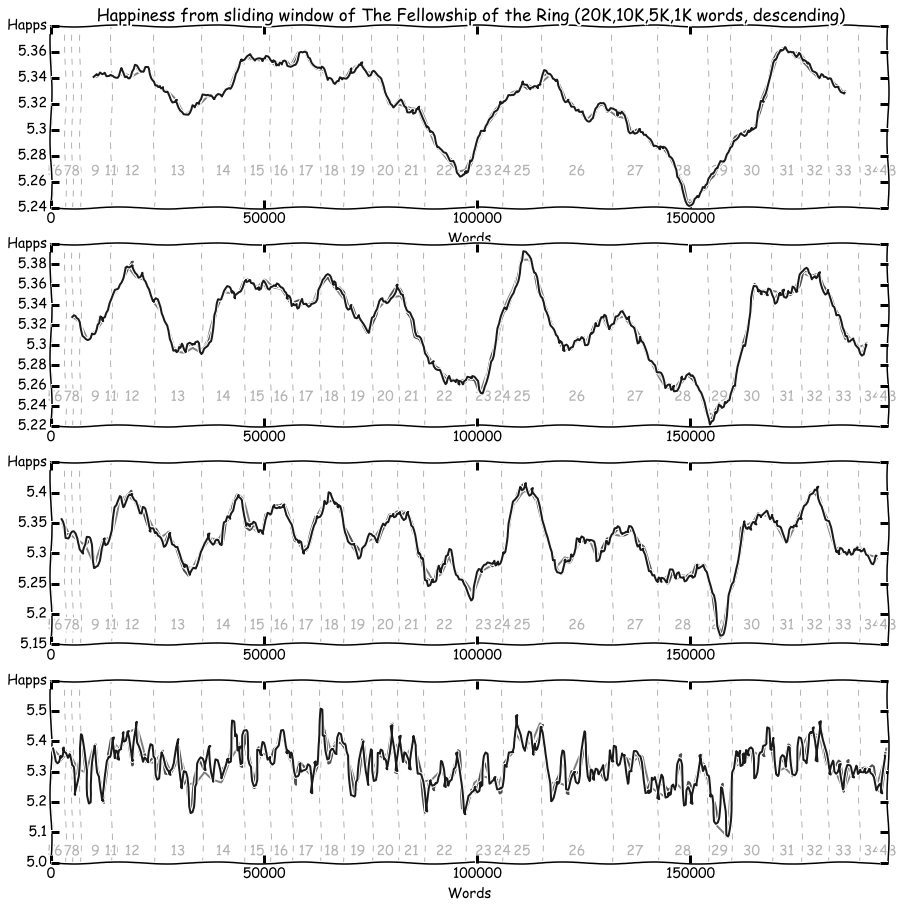

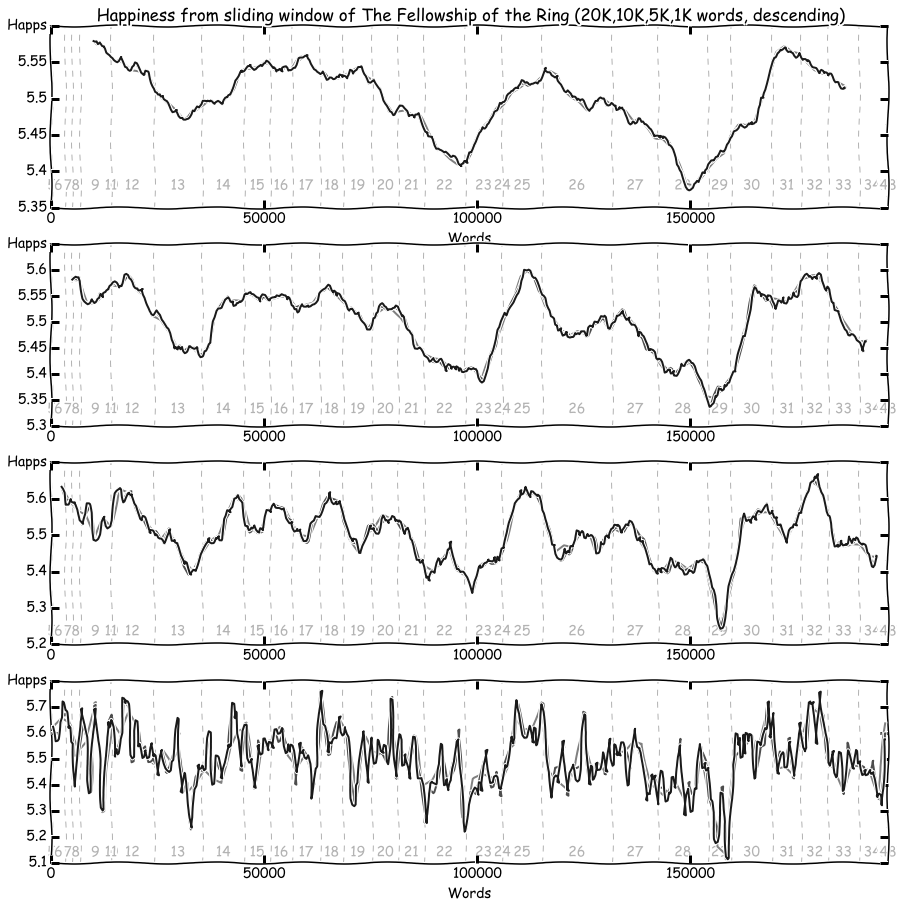

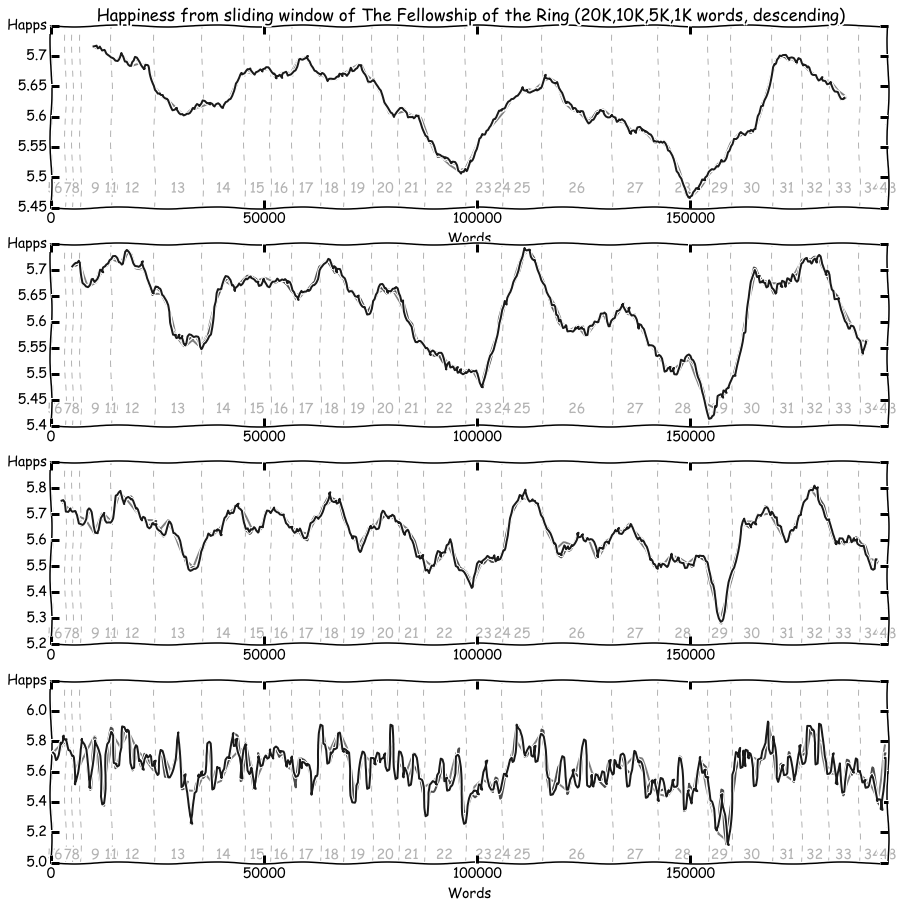

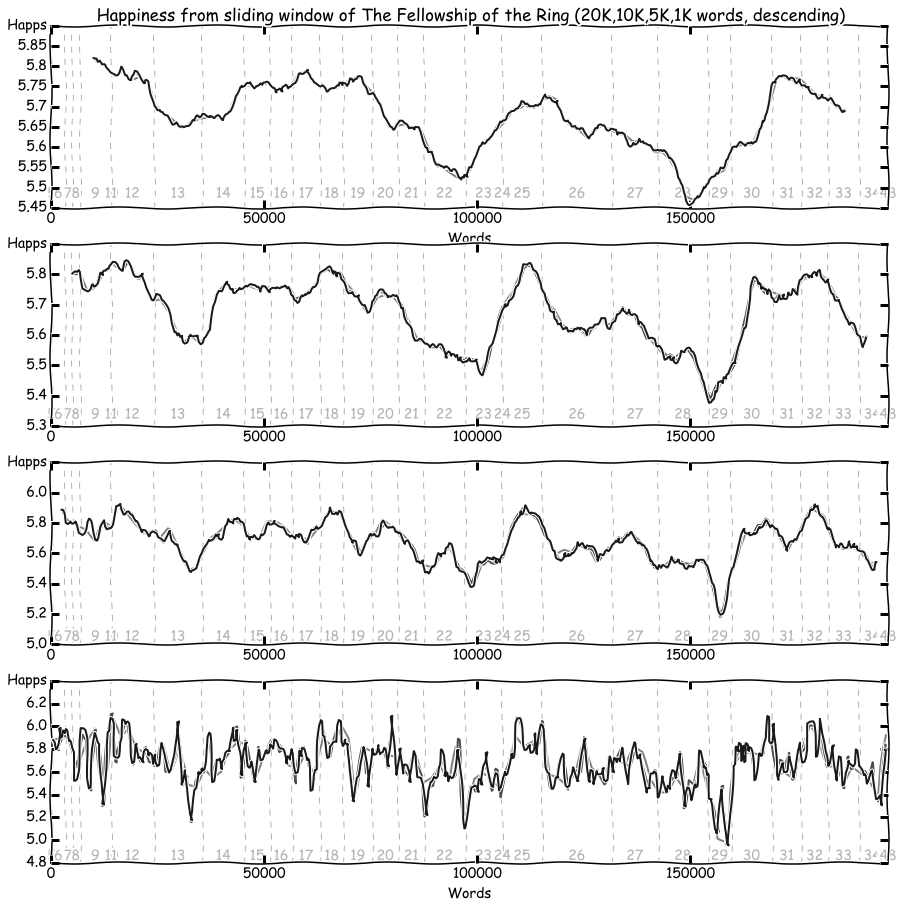

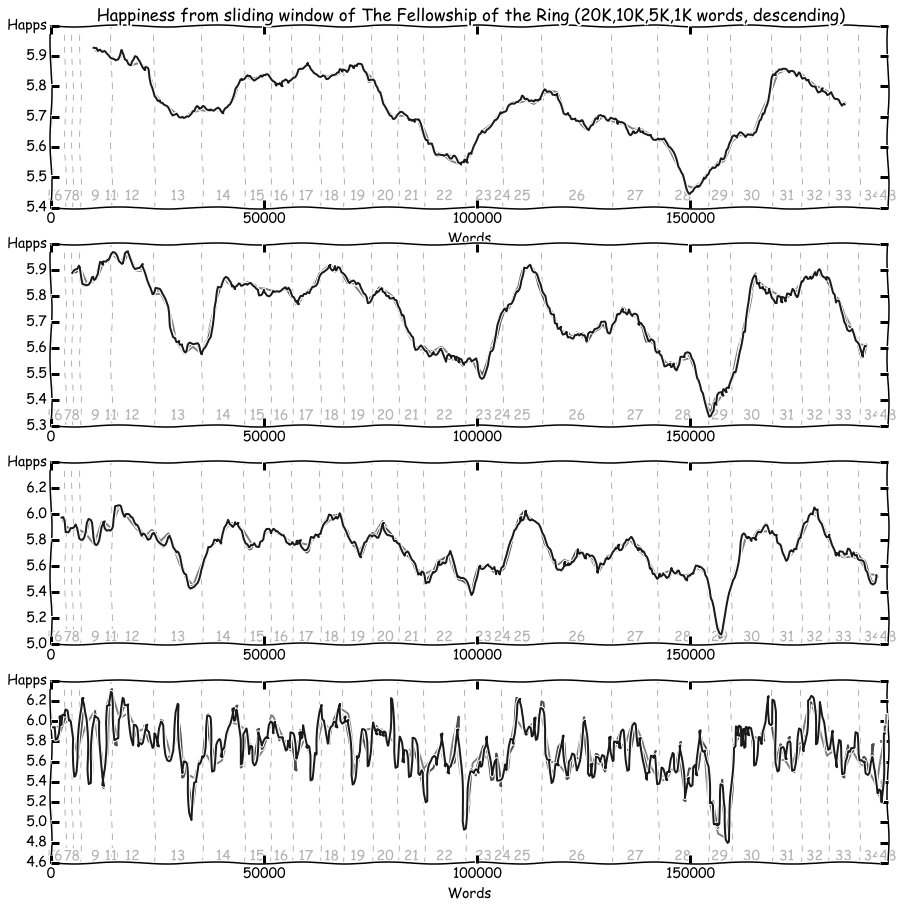

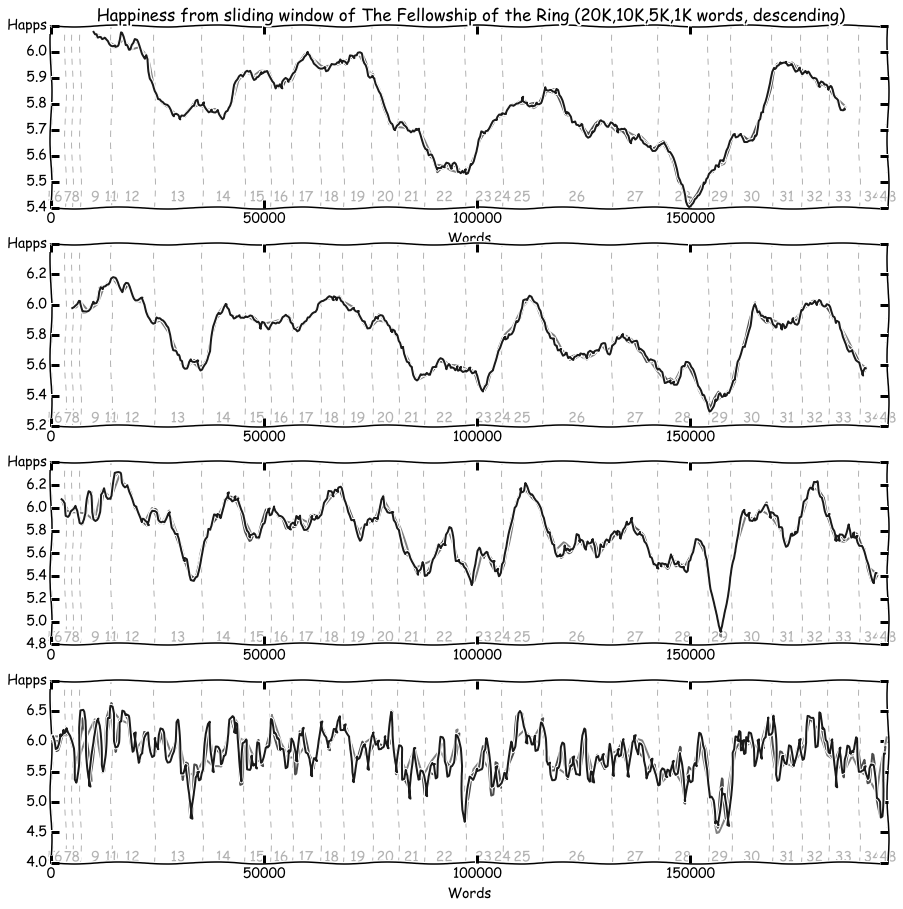

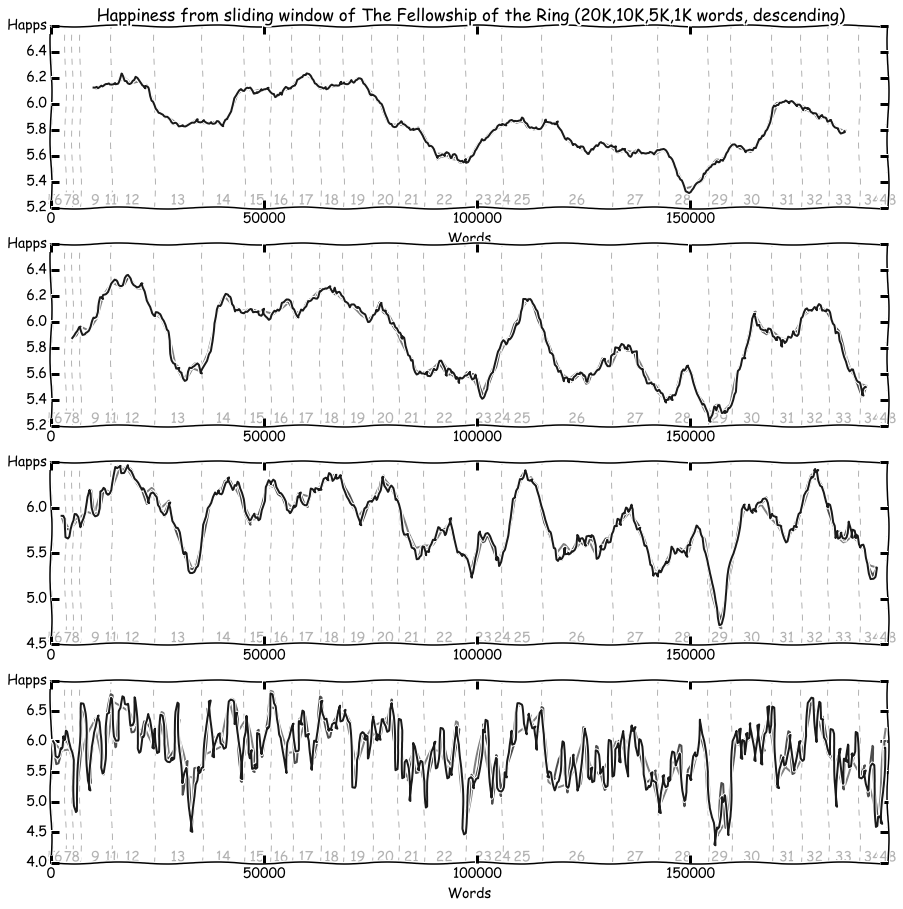

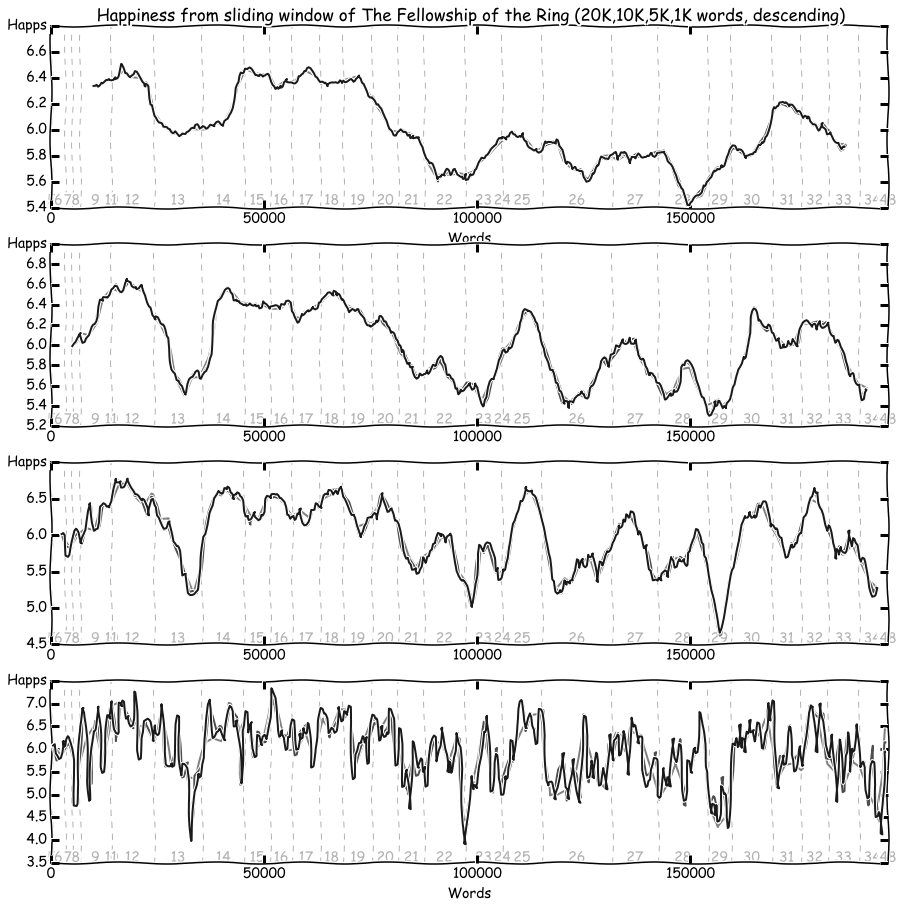

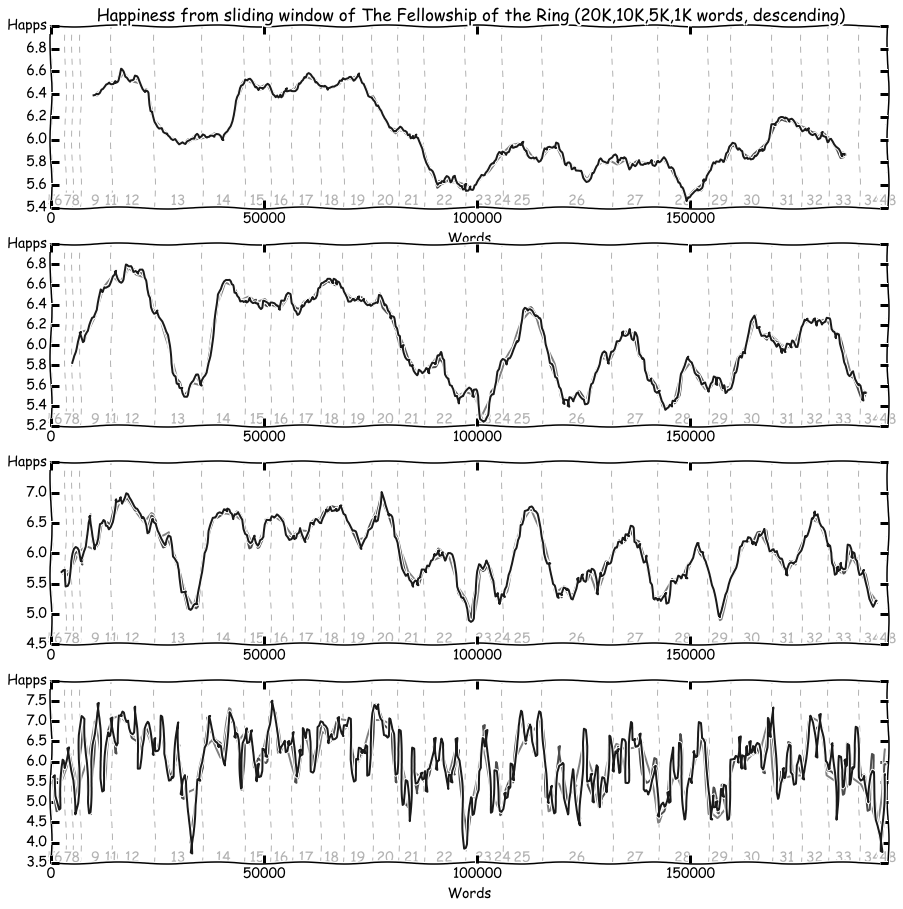

In [156]:
# # plt.rcdefaults()
# # %matplotlib inline
# plt.xkcd()
# fig = plt.figure(figsize=(18,5),dpi=600)
# ax = fig.add_axes([.2,.2,.7,.7])

stop_val = 0.0
2
    plt.figure(figsize=(15,15))
    ax = plt.subplot(4,1,1)
    min_size = 20000
    timeseries_100,all_fvecs,centers_100 = my_book.chopper_sliding(my_LabMT,min_size=min_size,stop_val=stop_val,return_centers=True)
    timeseries_200,all_fvecs,centers_200 = my_book.chopper_sliding(my_LabMT,num_points=200,min_size=min_size,stop_val=stop_val,return_centers=True)
    timeseries_500,all_fvecs,centers_500 = my_book.chopper_sliding(my_LabMT,num_points=500,min_size=min_size,stop_val=stop_val,return_centers=True)
    ax.plot(centers_100,timeseries_100,linestyle="-",marker="",color="0.5",markerfacecolor="0.1",markersize=3.5,zorder=3)
    ax.plot(centers_200,timeseries_200,linestyle="-",marker="",color="0.3",markerfacecolor="0.1",markersize=3.5,zorder=4)
    ax.plot(centers_500,timeseries_500,linestyle="-",marker="",color="0.1",markerfacecolor="0.1",markersize=3.5,zorder=5)
    new_ticks = [x for x in ax.yaxis.get_ticklocs()]
    ax.set_yticks(new_ticks)
    new_ticks[-1] = "Happs"
    ax.set_yticklabels(new_ticks)
    ax.set_xlabel("Words")
    ax.set_title("Happiness from sliding window of {} (20K,10K,5K,1K words, descending)".format(my_book.metadata["title"]))
    ax.set_xlim([my_book.chapter_beginnings[0],my_book.chapter_ends[-1]])

    for i,end in enumerate(my_book.chapter_ends):
        ax.plot([end,end],[ax.yaxis.get_ticklocs()[0],ax.yaxis.get_ticklocs()[-1]],'--',linewidth=1.0,color="0.7",zorder=1)
        ax.text(my_book.chapter_centers[i],ax.yaxis.get_ticklocs()[0]+0.025,i+1,horizontalalignment='center',color="0.7",zorder=1)

    ax = plt.subplot(4,1,2)
    min_size = 10000
    timeseries_100,all_fvecs,centers_100 = my_book.chopper_sliding(my_LabMT,min_size=min_size,stop_val=stop_val,return_centers=True)
    timeseries_200,all_fvecs,centers_200 = my_book.chopper_sliding(my_LabMT,num_points=200,min_size=min_size,stop_val=stop_val,return_centers=True)
    timeseries_500,all_fvecs,centers_500 = my_book.chopper_sliding(my_LabMT,num_points=500,min_size=min_size,stop_val=stop_val,return_centers=True)
    ax.plot(centers_100,timeseries_100,linestyle="-",marker="",color="0.5",markerfacecolor="0.1",markersize=3.5,zorder=3)
    ax.plot(centers_200,timeseries_200,linestyle="-",marker="",color="0.3",markerfacecolor="0.1",markersize=3.5,zorder=4)
    ax.plot(centers_500,timeseries_500,linestyle="-",marker="",color="0.1",markerfacecolor="0.1",markersize=3.5,zorder=5)
    new_ticks = [x for x in ax.yaxis.get_ticklocs()]
    ax.set_yticks(new_ticks)
    new_ticks[-1] = "Happs"
    ax.set_yticklabels(new_ticks)
    ax.set_xlim([my_book.chapter_beginnings[0],my_book.chapter_ends[-1]])

    for i,end in enumerate(my_book.chapter_ends):
        ax.plot([end,end],[ax.yaxis.get_ticklocs()[0],ax.yaxis.get_ticklocs()[-1]],'--',linewidth=1.0,color="0.7",zorder=1)
        ax.text(my_book.chapter_centers[i],ax.yaxis.get_ticklocs()[0]+0.025,i+1,horizontalalignment='center',color="0.7",zorder=1)

    ax = plt.subplot(4,1,3)
    min_size = 5000
    timeseries_100,all_fvecs,centers_100 = my_book.chopper_sliding(my_LabMT,min_size=min_size,stop_val=stop_val,return_centers=True)
    timeseries_200,all_fvecs,centers_200 = my_book.chopper_sliding(my_LabMT,num_points=200,min_size=min_size,stop_val=stop_val,return_centers=True)
    timeseries_500,all_fvecs,centers_500 = my_book.chopper_sliding(my_LabMT,num_points=500,min_size=min_size,stop_val=stop_val,return_centers=True)
    ax.plot(centers_100,timeseries_100,linestyle="-",marker="",color="0.5",markerfacecolor="0.1",markersize=3.5,zorder=3)
    ax.plot(centers_200,timeseries_200,linestyle="-",marker="",color="0.3",markerfacecolor="0.1",markersize=3.5,zorder=4)
    ax.plot(centers_500,timeseries_500,linestyle="-",marker="",color="0.1",markerfacecolor="0.1",markersize=3.5,zorder=5)
    new_ticks = [x for x in ax.yaxis.get_ticklocs()]
    ax.set_yticks(new_ticks)
    new_ticks[-1] = "Happs"
    ax.set_yticklabels(new_ticks)
    ax.set_xlim([my_book.chapter_beginnings[0],my_book.chapter_ends[-1]])

    for i,end in enumerate(my_book.chapter_ends):
        ax.plot([end,end],[ax.yaxis.get_ticklocs()[0],ax.yaxis.get_ticklocs()[-1]],'--',linewidth=1.0,color="0.7",zorder=1)
        ax.text(my_book.chapter_centers[i],ax.yaxis.get_ticklocs()[0]+0.025,i+1,horizontalalignment='center',color="0.7",zorder=1)

    ax = plt.subplot(4,1,4)
    min_size = 1000
    timeseries_100,all_fvecs,centers_100 = my_book.chopper_sliding(my_LabMT,min_size=min_size,stop_val=stop_val,return_centers=True)
    timeseries_200,all_fvecs,centers_200 = my_book.chopper_sliding(my_LabMT,num_points=200,min_size=min_size,stop_val=stop_val,return_centers=True)
    timeseries_500,all_fvecs,centers_500 = my_book.chopper_sliding(my_LabMT,num_points=500,min_size=min_size,stop_val=stop_val,return_centers=True)
    ax.plot(centers_100,timeseries_100,linestyle="-",marker="",color="0.5",markerfacecolor="0.1",markersize=3.5,zorder=3)
    ax.plot(centers_200,timeseries_200,linestyle="-",marker="",color="0.3",markerfacecolor="0.1",markersize=3.5,zorder=4)
    ax.plot(centers_500,timeseries_500,linestyle="-",marker="",color="0.1",markerfacecolor="0.1",markersize=3.5,zorder=5)
    new_ticks = [x for x in ax.yaxis.get_ticklocs()]
    ax.set_yticks(new_ticks)
    new_ticks[-1] = "Happs"
    ax.set_yticklabels(new_ticks)
    ax.set_xlabel("Words")
    ax.set_xlim([my_book.chapter_beginnings[0],my_book.chapter_ends[-1]])

    for i,end in enumerate(my_book.chapter_ends):
        ax.plot([end,end],[ax.yaxis.get_ticklocs()[0],ax.yaxis.get_ticklocs()[-1]],'--',linewidth=1.0,color="0.7",zorder=1)
        ax.text(my_book.chapter_centers[i],ax.yaxis.get_ticklocs()[0]+0.025,i+1,horizontalalignment='center',color="0.7",zorder=1)

    plt.savefig("media/figures/"+str(my_book.isbn)+"-timeseries-comparison-{0:.0f}.png".format(stop_val*100),bbox_inches="tight")
    plt.savefig("media/figures/"+str(my_book.isbn)+"-timeseries-comparison-{0:.0f}.pdf".format(stop_val*100),bbox_inches="tight")